In [17]:
import scipy
import os
import warnings
import numpy as np
from model import DGN
from scipy.io import loadmat
import matplotlib.pyplot as plt
import torch.nn
import contextlib
import sys
import helper


plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['DejaVu Serif', 'Arial', 'Liberation Serif']

#### 1. inspect

#### 2. data preprocessing

In [18]:
def normalize_matrix(connectivity_matrix):
    np.fill_diagonal(connectivity_matrix, 0)
    connectivity_matrix[np.logical_or(np.isinf(connectivity_matrix), np.isnan(connectivity_matrix))] = 0
    connectivity_matrix = connectivity_matrix.astype(float)
    
    return connectivity_matrix

In [19]:
import scipy.io
import numpy as np

connectivity_matrices_asd = []

for i in range(1, 155):
    mat = scipy.io.loadmat(f'data_nc_asd_R/data_nc_asd_R/ASD_RH/RHASDSub{i}.mat')
    connectivity_matrix = mat['views'][:, :, :]
    connectivity_matrix = [normalize_matrix(mat) for mat in connectivity_matrix]
    connectivity_matrices_asd.append(connectivity_matrix)

connectivity_matrices_asd = np.stack(connectivity_matrices_asd)

connectivity_matrices_control = []

for i in range(1, 186):
    mat = scipy.io.loadmat(f'data_nc_asd_R/data_nc_asd_R/NC_RH/RHNCSub{i}.mat')
    connectivity_matrix = mat['views'][:, :, :]
    connectivity_matrix = [normalize_matrix(mat) for mat in connectivity_matrix]
    connectivity_matrices_control.append(connectivity_matrix)

connectivity_matrices_control = np.stack(connectivity_matrices_control)


In [20]:
warnings.filterwarnings("ignore", category=UserWarning)

#### 3. train DGN for ASD

In [14]:
Dataset = "E" 

#Number of simulated subjects (overwriten if Dataset = "E") 
N_Subjects = 155

#Number of nodes for simulated brain networks (overwriten if Dataset = "E") 
N_Nodes = 35

#Number of brain views (overwriten if Dataset = "E")
N_views = 6

#Number of training epochs
N_max_epochs = 500

#Apply early stopping True/False
early_stop =  True

#Random subset size for SNL function  
random_sample_size = 10

#Number of cross validation folds
n_folds = 5

#Learning Rate for Adam optimizer
lr = 0.001

#Name of the model
model_name = "TOPOLOGICAL_EVALUATION_TEST_SET"

#dimension of embeddings output by the first GDL layer (for each ROI)
CONV1 = 8
#dimension of embeddings output by the second GDL layer (for each ROI)
CONV2 = 8
#dimension of embeddings output by the third GDL layer (for each ROI)
CONV3 = 8

lambda1 = 200
lambda2 = 50
patience = 3

#----------------------------------------------------------------------------#
#----------------------------------------------------------------------------#
#                 Below is not to be modified manually                       #
#----------------------------------------------------------------------------#
#----------------------------------------------------------------------------#

import helper

if Dataset.lower() not in ["e", "E", "s", "S"]:
    raise ValueError("Dataset options are E or S.")
    
if (Dataset.lower() == "e"):
    X = connectivity_matrices_asd
    N_Subjects = X.shape[0]
    N_Nodes = X.shape[1]
    N_views = X.shape[3]
else:
    X = helper.create_better_simulated(N_Subjects, N_Nodes) if N_views == 4 else helper.simulate_dataset(N_Subjects, N_Nodes, N_views)


CONFIG = {
        "X": X,
        "N_ROIs":  X.shape[1],
        "N_views":  X.shape[3],
        "N_max_epochs": N_max_epochs,
        "n_folds": n_folds,
        "random_sample_size": random_sample_size,
        "early_stop": early_stop,
        "model_name": model_name
    }

MODEL_PARAMS = {
        "N_ROIs": N_Nodes,
        "learning_rate" : lr,
        "n_attr": X.shape[3],
        "Linear1" : {"in": N_views, "out": CONV1},
        "conv1": {"in" : 1, "out": CONV1},
        
        "Linear2" : {"in": N_views, "out": CONV1*CONV2},
        "conv2": {"in" : CONV1, "out": CONV2},
        
        "Linear3" : {"in": N_views, "out": CONV2*CONV3},
        "conv3": {"in" : CONV2, "out": CONV3},
        "lambda1" : lambda1,
        "lambda2" : lambda2,
        "patience" : patience,
    }

In [10]:
# lambda2 = 50
np.random.seed(35813)
torch.manual_seed(35813)
models = DGN.train_model(
                CONFIG["X"],
                model_params=MODEL_PARAMS,
                n_max_epochs=CONFIG["N_max_epochs"],
                n_folds=CONFIG["n_folds"],
                random_sample_size=CONFIG["random_sample_size"],
                early_stop=CONFIG["early_stop"],
                model_name=CONFIG["model_name"])

********* FOLD 0 *********
Epoch: 0  |  cbt loss : 26.92 | reservoir loss : 0.0937 | bio loss : 0.59640 | total loss: 75.48 | median cbt mc 10.01 | Time Elapsed: 18.65 | 
Epoch: 10  |  cbt loss : 18.46 | reservoir loss : 0.0928 | bio loss : 0.56990 | total loss: 65.53 | median cbt mc 10.22 | Time Elapsed: 36.73 | 
Epoch: 20  |  cbt loss : 15.46 | reservoir loss : 0.0926 | bio loss : 0.58194 | total loss: 63.08 | median cbt mc 10.27 | Time Elapsed: 40.82 | 
Epoch: 30  |  cbt loss : 13.50 | reservoir loss : 0.0925 | bio loss : 0.58755 | total loss: 61.38 | median cbt mc 10.14 | Time Elapsed: 38.28 | 
Epoch: 40  |  cbt loss : 12.61 | reservoir loss : 0.0925 | bio loss : 0.58971 | total loss: 60.59 | median cbt mc 10.26 | Time Elapsed: 37.10 | 
Epoch: 50  |  cbt loss : 12.11 | reservoir loss : 0.0925 | bio loss : 0.57218 | total loss: 59.21 | median cbt mc 10.27 | Time Elapsed: 37.38 | 
Epoch: 60  |  cbt loss : 11.75 | reservoir loss : 0.0925 | bio loss : 0.57545 | total loss: 59.01 | medi

KeyboardInterrupt: 

In [ ]:
models = DGN.train_model(
                CONFIG["X"],
                model_params=MODEL_PARAMS,
                n_max_epochs=CONFIG["N_max_epochs"],
                n_folds=CONFIG["n_folds"],
                random_sample_size=CONFIG["random_sample_size"],
                early_stop=CONFIG["early_stop"],
                model_name=CONFIG["model_name"])

********* FOLD 0 *********
Epoch: 0  |  cbt loss : 18.74 | reservoir loss : 0.0832 | bio loss : 0.88270 | total loss: 44.21 | median cbt mc 9.28 | Time Elapsed: 14.64 | 
Epoch: 10  |  cbt loss : 13.99 | reservoir loss : 0.0832 | bio loss : 0.59408 | total loss: 36.57 | median cbt mc 10.26 | Time Elapsed: 34.89 | 
Epoch: 20  |  cbt loss : 11.91 | reservoir loss : 0.0832 | bio loss : 0.63179 | total loss: 34.87 | median cbt mc 10.27 | Time Elapsed: 36.27 | 


KeyboardInterrupt: 

********* FOLD 0 *********
Epoch: 0  |  cbt loss : 58.45 | reservoir loss : 0.0877 | bio loss : 0.00010 | total loss: 84.76 | median cbt mc 9.27 | Time Elapsed: 1.63 | 
Epoch: 10  |  cbt loss : 48.88 | reservoir loss : 0.0874 | bio loss : 0.00011 | total loss: 75.09 | median cbt mc 9.29 | Time Elapsed: 8.21 | 
Epoch: 20  |  cbt loss : 40.89 | reservoir loss : 0.0873 | bio loss : 0.00230 | total loss: 67.06 | median cbt mc 9.29 | Time Elapsed: 8.31 | 
Epoch: 30  |  cbt loss : 34.92 | reservoir loss : 0.0872 | bio loss : 0.07032 | total loss: 61.08 | median cbt mc 9.29 | Time Elapsed: 7.77 | 
Epoch: 40  |  cbt loss : 30.05 | reservoir loss : 0.0872 | bio loss : 0.19104 | total loss: 56.21 | median cbt mc 9.70 | Time Elapsed: 7.69 | 
Epoch: 50  |  cbt loss : 26.29 | reservoir loss : 0.0872 | bio loss : 0.33107 | total loss: 52.45 | median cbt mc 9.32 | Time Elapsed: 7.96 | 
Epoch: 60  |  cbt loss : 23.10 | reservoir loss : 0.0872 | bio loss : 0.43491 | total loss: 49.26 | median cbt mc 10

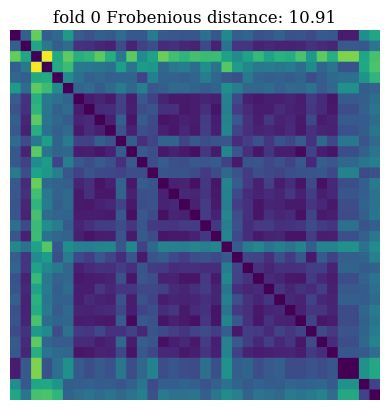

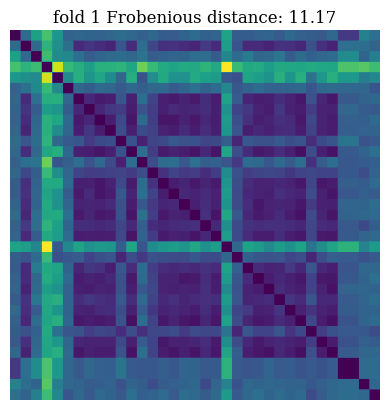

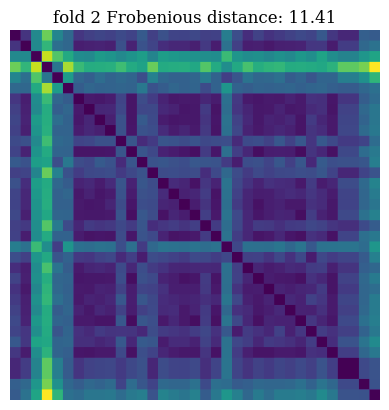

In [ ]:
models = DGN.train_model(
                CONFIG["X"],
                model_params=MODEL_PARAMS,
                n_max_epochs=CONFIG["N_max_epochs"],
                n_folds=CONFIG["n_folds"],
                random_sample_size=CONFIG["random_sample_size"],
                early_stop=CONFIG["early_stop"],
                model_name=CONFIG["model_name"])

********* FOLD 0 *********
Epoch: 0  |  cbt loss : 27.67 | reservoir loss : 0.1109 | bio loss : 0.01083 | total loss: 61.04 | median cbt mc 10.45 | Time Elapsed: 3.26 | 
Epoch: 10  |  cbt loss : 22.30 | reservoir loss : 0.1100 | bio loss : 0.85027 | total loss: 63.80 | median cbt mc 9.52 | Time Elapsed: 7.55 | 
Epoch: 20  |  cbt loss : 19.24 | reservoir loss : 0.1098 | bio loss : 0.00044 | total loss: 52.18 | median cbt mc 10.44 | Time Elapsed: 7.76 | 
Epoch: 30  |  cbt loss : 17.38 | reservoir loss : 0.1097 | bio loss : 0.00021 | total loss: 50.29 | median cbt mc 10.45 | Time Elapsed: 7.73 | 
Epoch: 40  |  cbt loss : 16.07 | reservoir loss : 0.1097 | bio loss : 0.00010 | total loss: 48.96 | median cbt mc 10.45 | Time Elapsed: 7.95 | 
Epoch: 50  |  cbt loss : 14.91 | reservoir loss : 0.1096 | bio loss : 0.00005 | total loss: 47.81 | median cbt mc 10.46 | Time Elapsed: 7.79 | 
Epoch: 60  |  cbt loss : 14.07 | reservoir loss : 0.1096 | bio loss : 0.00003 | total loss: 46.96 | median cbt 

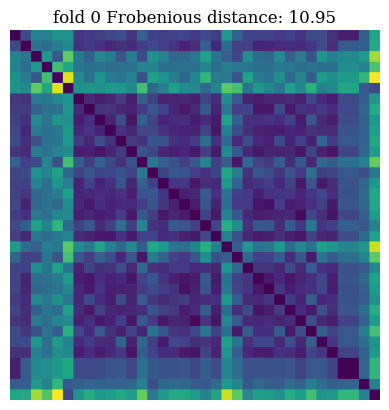

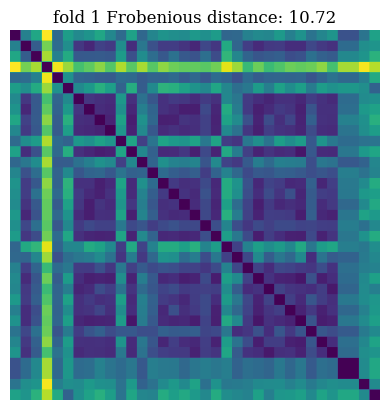

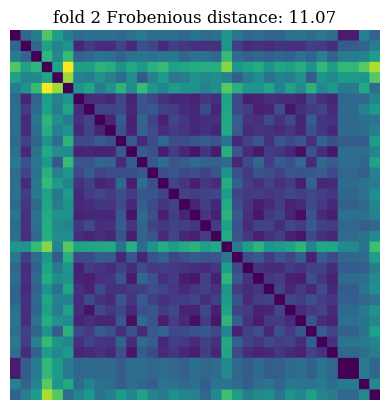

In [ ]:
models = DGN.train_model(
                CONFIG["X"],
                model_params=MODEL_PARAMS,
                n_max_epochs=CONFIG["N_max_epochs"],
                n_folds=CONFIG["n_folds"],
                random_sample_size=CONFIG["random_sample_size"],
                early_stop=CONFIG["early_stop"],
                model_name=CONFIG["model_name"])

In [ ]:
models = DGN.train_model(
                CONFIG["X"],
                model_params=MODEL_PARAMS,
                n_max_epochs=CONFIG["N_max_epochs"],
                n_folds=CONFIG["n_folds"],
                random_sample_size=CONFIG["random_sample_size"],
                early_stop=CONFIG["early_stop"],
                model_name=CONFIG["model_name"])

In [ ]:
DGN_data = [0.5961953014932777,
0.5598844649573573,
0.6139022733171018,
0.5768424629763399,
0.5886695077737425]

bio_data = [0.5654812297443681,
0.5835609595319242,
0.6043396375229418,
0.5763508480047119,
0.5905560074719867]

In [ ]:
print("DGN_data", np.mean(DGN_data))
print("bio_data", np.mean(bio_data))

DGN_data 0.5870988021035639
bio_data 0.5840577364551865


In [ ]:
bio_laa_mc = []